# Angle error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import DBSCAN

In [2]:
### Import the data
error_data = pd.read_csv("angle_error_data.csv")

In [3]:
ANGLE_LIMIT_DEG = 70

### 1. Data visualization

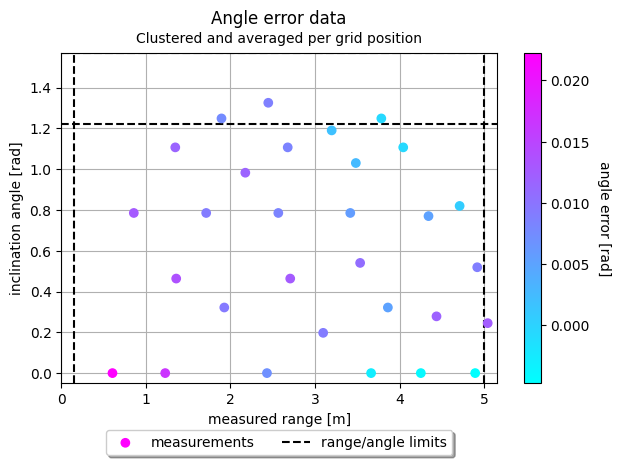

In [4]:
### Cluster the measurements per grid position

plt.close("all")
fig, ax = plt.subplots(1, 1)

ranges, angles, errors = error_data["ranges"], error_data["angles"], error_data["errors"]

db = DBSCAN(eps=0.2, min_samples=10).fit(np.vstack((ranges, angles)).T)
labels = db.labels_

cluster_error_data = []
for l in np.unique(labels):
    ranges_cluster = ranges[labels == l]
    angles_cluster = angles[labels == l]
    errors_cluster = errors[labels == l]
    center = ranges_cluster.mean(), angles_cluster.mean()
    error_mean, error_std = errors_cluster.mean(), errors_cluster.std()
    cluster_error_data.append([*center, error_mean, error_std])

cluster_error_data = np.array(cluster_error_data)

ranges_mean, angles_mean, errors_mean, errors_std = cluster_error_data.T
ax.scatter(ranges_mean, angles_mean, c=errors_mean, cmap="cool", label="measurements", zorder=10)

ax.set_xlim(0, 5.15)
ax.set_ylim(-0.05, np.pi / 2)
ax.vlines(0.15, *ax.get_ylim(), color="k", linestyles="--", label="range/angle limits")
ax.vlines(5, *ax.get_ylim(), color="k", linestyles="--")
ax.hlines(np.pi / 2, *ax.get_xlim(), color="k", linestyles="--")
ax.hlines(np.radians(ANGLE_LIMIT_DEG), *ax.get_xlim(), color="k", linestyles="--")

ax.set_xlabel("measured range [m]")
ax.set_ylabel("inclination angle [rad]")
ax.set_title("Angle error data\n")
ax.text(0.5, 1.03, "Clustered and averaged per grid position", fontsize=10, ha="center", transform=ax.transAxes)
# plt.title(subtitle_string, fontsize=10)

ax.grid()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=5)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(errors_mean.min(), errors_mean.max()), cmap="cool"), ax=ax
)
cbar.set_label("angle error [rad]", rotation=270, labelpad=15)
plt.tight_layout()

plt.savefig("angle_error_data.pdf", bbox_inches="tight")
plt.savefig("angle_error_data.png", dpi=300, bbox_inches="tight")

### 2. Model fit

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Ignore the GPU

### Import the `lib` directory
import pathlib
import sys

repo_directory = pathlib.Path().resolve().parents[1]
lib_module_dir = str(repo_directory.joinpath("lib"))
if lib_module_dir not in sys.path:
    sys.path.insert(0, str(repo_directory.joinpath("lib")))

from dual_gp_model_SVGP import DualGaussianProcessWrapper, make_train_test_split


2024-08-14 07:04:17.578979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 07:04:18.453951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
EPOCHS: int = 500  # 500
INDUCING_POINTS: int = 10
GRID_SIZE: int = 1000
LEARNING_RATE_FACTOR: float = 0.01
SCALE_FACTOR: float = 100

In [7]:
GP_model = DualGaussianProcessWrapper(
    x_data=np.vstack([error_data["ranges"], error_data["angles"]]).T,
    y_data=error_data["errors"].to_numpy(),
    train_mask=make_train_test_split(len(error_data)),
    no_inducing_points=INDUCING_POINTS,
    data_directory=str(pathlib.Path().resolve()),  # current directory
    scale_factor=SCALE_FACTOR,
)

2024-08-14 07:04:22.708768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-14 07:04:22.708805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: christiaan-HP-ZBook-Studio-G5
2024-08-14 07:04:22.708811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: christiaan-HP-ZBook-Studio-G5
2024-08-14 07:04:22.708965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-08-14 07:04:22.708990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.90.7
2024-08-14 07:04:22.708995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.90.7


Going to train for 500 epochs...


  0%|          | 0/500 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


2024-08-14 07:04:26.873692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-14 07:04:26.910340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -7488.21 	 test_elbo = -1872.09
Epoch 2: 	 train_elbo = -7380.85 	 test_elbo = -1845.21
Epoch 3: 	 train_elbo = -7268.52 	 test_elbo = -1816.99
Epoch 4: 	 train_elbo = -7146.99 	 test_elbo = -1786.31
Epoch 5: 	 train_elbo = -7013.10 	 test_elbo = -1752.35
Epoch 6: 	 train_elbo = -6865.39 	 test_elbo = -1714.71
Epoch 7: 	 train_elbo = -6705.00 	 test_elbo = -1673.67
Epoch 8: 	 train_elbo = -6535.74 	 test_elbo = -1630.19
Epoch 9: 	 train_elbo = -6364.21 	 test_elbo = -1585.96
Epoch 10: 	 train_elbo = -6198.77 	 test_elbo = -1543.15
Epoch 11: 	 train_elbo = -6047.23 	 test_elbo = -1503.78
Epoch 12: 	 train_elbo = -5914.75 	 test_elbo = -1469.23
Epoch 13: 	 train_elbo = -5802.31 	 test_elbo = -1439.82
Epoch 14: 	 train_elbo = -5707.74 	 test_elbo = -1415.06
Epoch 15: 	 train_elbo = -5627.36 	 test_elbo = -1394.06
Epoch 16: 	 train_elbo = -5557.81 	 test_elbo = -1375.96
Epoch 17: 	 train_elbo = -5496.44 	 test_elbo = -1360.09
Epoch 18: 	 train_elbo = -5441.47 	 test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 500: 	 train_elbo = -4138.99 	 test_elbo = -1092.21
Plotting the posterior...


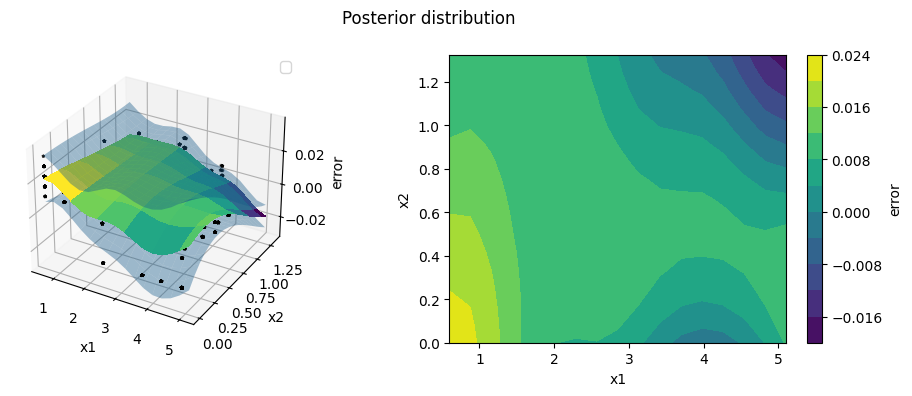

Generating the error model (interpolation grid)...


2024-08-14 07:14:26.386688: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-14 07:14:27.661917: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-14 07:14:29.410568: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-14 07:14:30.122291: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-14 07:14:30.836914: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.


Saving the error model...
Done


In [8]:
print(f"Going to train for {EPOCHS} epochs...")
GP_model.train(epochs=EPOCHS, lr_factor=LEARNING_RATE_FACTOR)
print(f"Plotting the posterior...")
GP_model.plot_posterior()
print(f"Generating the error model (interpolation grid)...")
GP_model.generate_error_model(
    grid_size=GRID_SIZE, model_info={"error": "Lidar angle error", "param1": "range", "param2": "angle"}
)
print(f"Saving the error model...")
GP_model.save_error_model()
print("Done")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_10624/2635613911.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cm = mpl.cm.get_cmap("viridis")


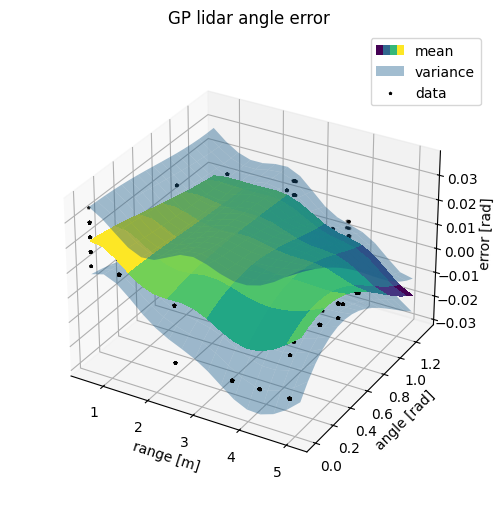

In [63]:
### Save the GP picture
from matplotlib.legend_handler import HandlerTuple

fig = GP_model.plot_posterior(return_fig=True)
ax1, ax2, cbar = fig.get_axes()
ax2.remove()
cbar.remove()
ax1.set_xlabel("range [m]")
ax1.set_ylabel("angle [rad]")
ax1.set_zlabel("error [rad]")

fig.suptitle("")
ax1.set_title("GP lidar angle error")

ax1.set_box_aspect(aspect=None, zoom=0.88)

# ax1.legend([ax1.get_children()[1], ax1.get_children()[2]], ["mean", "variance"])

steps = 4
viridis_cm = mpl.cm.get_cmap("viridis")
colourmap_handle = []
for i in range(steps):
    colourmap_handle.append(mpl.patches.Patch(facecolor=viridis_cm(i / (steps - 1))))

ax1.legend(
    [colourmap_handle, ax1.get_children()[2], ax1.get_children()[0]],
    ["mean", "variance", "data"],
    handler_map={list: HandlerTuple(None, pad=0)},
)

fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("angle_error_gp.pdf", bbox_inches="tight")
fig.savefig("angle_error_gp.png", dpi=300, bbox_inches="tight")

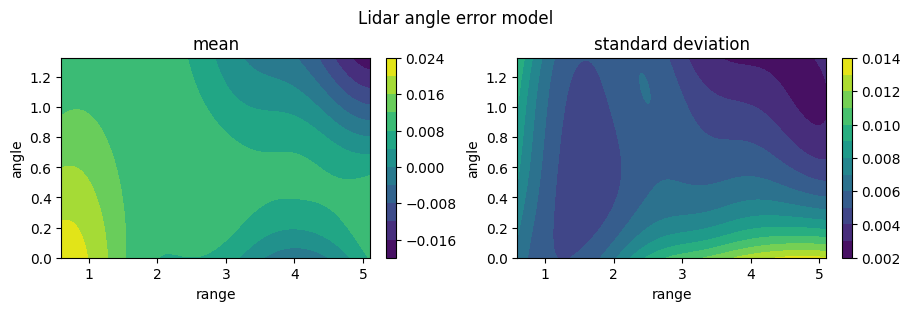

In [10]:
GP_model.error_model.plot()